In [1]:
#install necessary libraries and dependencies
!pip install tensorflow opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import tensorflow as tf 
import os #operating system interaction

In [3]:
import cv2 #for realtime computer vision
import imghdr #to determine the image type

In [69]:
#preprocessing 
#load data
#remove dodgy images

train_data_dir = 'data/train' #train data directory
test_data_dir = 'data/test' #test data directory

image_exts = ['jpeg','jpg', 'bmp', 'png'] #valid image extensions

In [70]:
#function to iterate through all images and remove ones with invalid extensions
def img_ext(data_dir):
    for image_class in os.listdir(data_dir):
        for image in os.listdir(os.path.join(data_dir, image_class)):
            image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            
img_ext(train_data_dir)
img_ext(test_data_dir)

In [71]:
tf.keras.utils.set_random_seed(12) #random seeding for consistency

batch_size = 32
#desired image dimensions
img_height = img_weight = 256

In [72]:
#data visualization
#import necessary libraries
import numpy as np
from matplotlib import pyplot as plt
train_data = tf.keras.utils.image_dataset_from_directory('data/train') #load data from train drectory

Found 1924 files belonging to 2 classes.


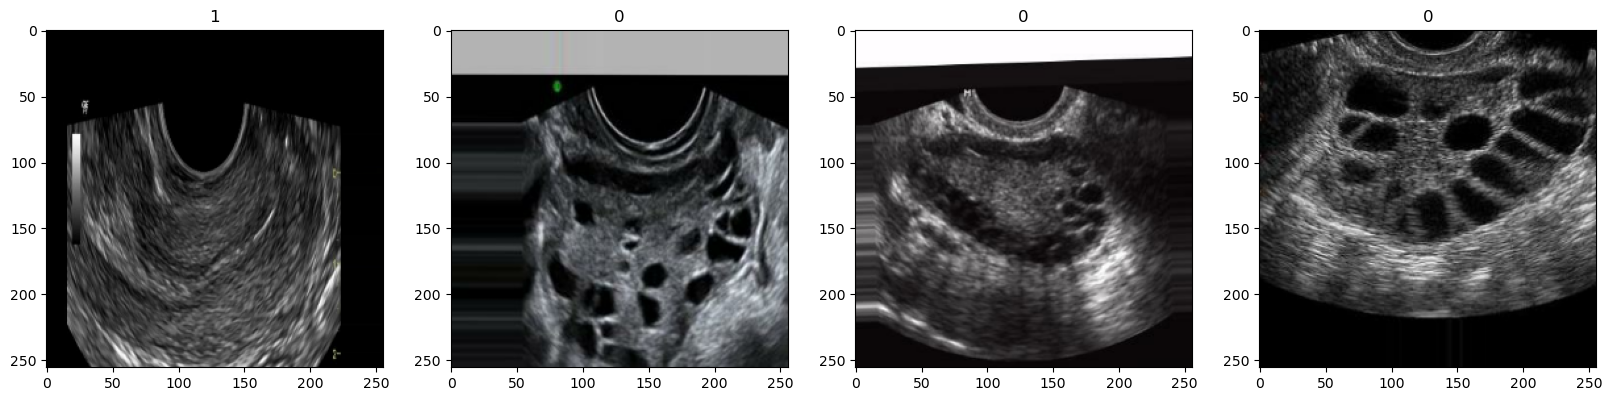

In [73]:
train_data_iterator = train_data.as_numpy_iterator() #to iterate through the dataset
batch = train_data_iterator.next() #display the data in batch
#display image and their classes
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    
    #from our visuualized images, we can see that label 0 indicates infected and 1 indicates not infected

In [74]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#data augmention and generators for training and validation
train_datagen = ImageDataGenerator(rescale = 1.0/255.0, #rescale pixel values to range 0 to 1
                                   shear_range = 0.2,  #apply shearing transformation to images
                                   zoom_range = 0.2, #apply random zoom to images up to 20%
                                   width_shift_range=0.2, #randomly shift the width of images up to 20%
                                   height_shift_range=0.2, #randomly shift the heigth of images up to 20%
                                   horizontal_flip = True, #horizontally flip images randomly
                                   vertical_flip=True, #vertically flip images randomly
                                   rotation_range=20, #randomly rotate images by up to 20 degrees
                                   validation_split=0.2, #split data into training and validation using 80:20 ratio
                                   fill_mode='nearest' #fill newly created pixels with the nearest pixel value
                                  )
#generator for training data
train_gen = train_datagen.flow_from_directory(train_data_dir,
                                              class_mode='categorical', #label encoding type for one-hot encoding
                                              classes=['infected', 'notinfected'], #prediction classes expected
                                              target_size=(img_height, img_weight), #resize image to specified dimensions
                                              batch_size=batch_size, #number of images per batch
                                              subset='training', #subset of data (in this case training)
                                              seed=12 #seeding for consistency
                                             )
#genarator for validation data
validation_gen = train_datagen.flow_from_directory(train_data_dir,
                                              class_mode='categorical', #label encoding type for one-hot encoding
                                              classes=['infected', 'notinfected'], #prediction classes expected
                                              target_size=(img_height, img_weight), #resize image to specified dimensions
                                              batch_size=batch_size, #number of images per batch
                                              subset='validation', #subset of data (in this case validation)
                                              seed=12 #seeding for consistency
                                             )

Found 1540 images belonging to 2 classes.
Found 384 images belonging to 2 classes.


In [22]:
#build model
#import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input

#input_shape = (256, 256, 3)
model = Sequential()

#model.add(Input(shape=input_shape))

#convolutional layer with 64 filters, each of size of 3by5 pixels, stride of 1 and ReLU activation
model.add(Conv2D(64, (5,5), 1, activation='relu', input_shape=(256,256,3)))

#max pooling layer scans through the values return after ReLU activation, condenses and returns the max value
model.add(MaxPooling2D(2, 2))

#convolutional layer with 32 filters
model.add(Conv2D(32, (5,5), 1, activation='relu'))

#max pooling layer
model.add(MaxPooling2D(2, 2))

#convolutional layer with 16 filters
model.add(Conv2D(16, (5,5), 1, activation='relu'))

#max pooling layer
model.add(MaxPooling2D(2, 2))

#flatten layer to flatten down the channel values to a single value
model.add(Flatten())

#fully connected layers with 256 neurons and ReLU activation
model.add(Dense(256, activation='relu'))

#model.add(Dropout(0.5))

#model.add(Dense(256, activation='relu'))

#model.add(Dropout(0.5))

#last layer is a single dense layer with sigmoid activation to represent our expected output of 0 or 1
#0 represents infected and 1 represent notinfected
model.add(Dense(2, activation='sigmoid'))

In [10]:
#import optimizer
from tensorflow.keras.optimizers import Adam

#opt=Adam() #optimizer for model compilation with learning rate of 0.01
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

NameError: name 'model' is not defined

In [75]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#early stopping allows to stop training when valudation loss does not decrease after 15 consequtive epochs.
earlyStopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=15)

In [25]:
history = model.fit(
    train_gen,
    validation_data=validation_gen,
    callbacks=[earlyStopping],
    batch_size=batch_size,
    verbose=1,
    epochs=20)

Epoch 1/20
49/49 [==============================] - 154s 3s/step - loss: 0.4183 - accuracy: 0.8286 - val_loss: 0.2413 - val_accuracy: 0.9349
Epoch 2/20
49/49 [==============================] - 153s 3s/step - loss: 0.1223 - accuracy: 0.9617 - val_loss: 0.0624 - val_accuracy: 0.9844
Epoch 3/20
49/49 [==============================] - 154s 3s/step - loss: 0.0326 - accuracy: 0.9870 - val_loss: 0.0466 - val_accuracy: 0.9922
Epoch 4/20
49/49 [==============================] - 152s 3s/step - loss: 0.1106 - accuracy: 0.9727 - val_loss: 0.0596 - val_accuracy: 0.9922
Epoch 5/20
49/49 [==============================] - 154s 3s/step - loss: 0.0493 - accuracy: 0.9851 - val_loss: 0.0223 - val_accuracy: 0.9922
Epoch 6/20
49/49 [==============================] - 153s 3s/step - loss: 0.0334 - accuracy: 0.9916 - val_loss: 0.0078 - val_accuracy: 1.0000
Epoch 7/20
49/49 [==============================] - 157s 3s/step - loss: 0.0260 - accuracy: 0.9942 - val_loss: 0.0649 - val_accuracy: 0.9870
Epoch 8/20
49

In [26]:
model.summary() #to view the architecture at every layer

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 252, 252, 64)      4864      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 122, 122, 32)      51232     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 61, 61, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 57, 57, 16)        12816     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 28, 28, 16)      

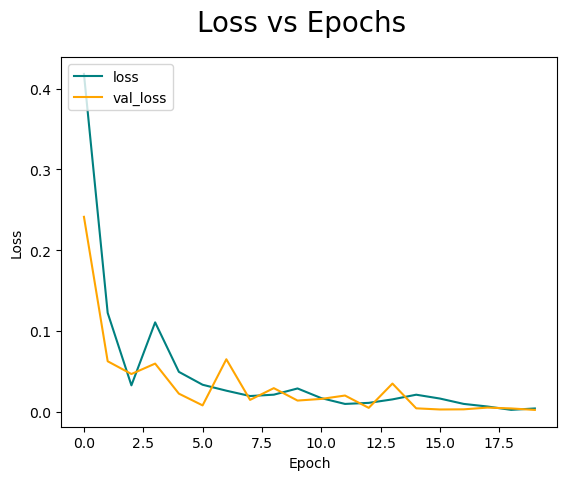

In [27]:
#plot the model training and validation performance loss
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss vs Epochs', fontsize=20)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

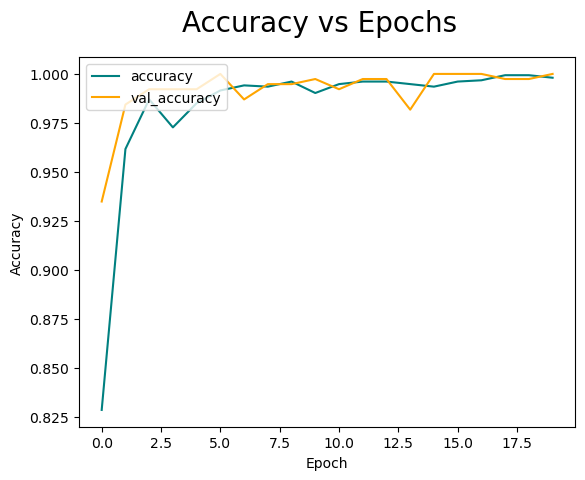

In [28]:
#plot the model training and validation performance accuracy
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy vs Epochs', fontsize=20)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [22]:
#evaluation and testing
#import the neccesary libraries
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [23]:
#load the test data
#test_data = train_datagen.flow_from_directory(
    #test_data_dir,
    #seed=12,
    #target_size=(img_height, img_weight),
   # batch_size=batch_size
#)
test_data = tf.keras.utils.image_dataset_from_directory('data/test')


Found 1922 files belonging to 2 classes.


In [24]:
#normalize test data
test_data = test_data.map(lambda x,y: (x/255, y))
test_data_iterator = test_data.as_numpy_iterator()
test_data.as_numpy_iterator().next()

(array([[[[1.17647061e-02, 1.17647061e-02, 1.17647061e-02],
          [1.17647061e-02, 1.17647061e-02, 1.17647061e-02],
          [8.27205926e-03, 8.27205926e-03, 8.27205926e-03],
          ...,
          [7.84313772e-03, 7.84313772e-03, 7.84313772e-03],
          [7.84313772e-03, 7.84313772e-03, 7.84313772e-03],
          [7.84313772e-03, 7.84313772e-03, 7.84313772e-03]],
 
         [[1.17647061e-02, 1.17647061e-02, 1.17647061e-02],
          [1.17647061e-02, 1.17647061e-02, 1.17647061e-02],
          [8.27205926e-03, 8.27205926e-03, 8.27205926e-03],
          ...,
          [7.84313772e-03, 7.84313772e-03, 7.84313772e-03],
          [7.84313772e-03, 7.84313772e-03, 7.84313772e-03],
          [7.84313772e-03, 7.84313772e-03, 7.84313772e-03]],
 
         [[1.17647061e-02, 1.17647061e-02, 1.17647061e-02],
          [1.17647061e-02, 1.17647061e-02, 1.17647061e-02],
          [8.27205926e-03, 8.27205926e-03, 8.27205926e-03],
          ...,
          [1.71568629e-03, 1.71568629e-03, 1.7156

In [32]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [35]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_pred_prob = model.predict(X)
    y_pred_binary = np.argmax(y_pred_prob, axis=1)
    
    pre.update_state(y, y_pred_binary)
    re.update_state(y, y_pred_binary)
    acc.update_state(y, y_pred_binary)

1/1 [==============================] - 0s 88ms/step


In [36]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


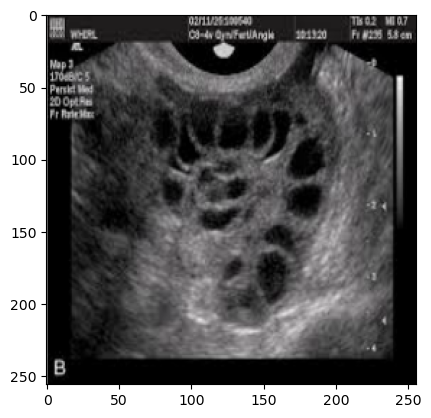

In [64]:
#test the model on real infected ultrasound image
img = cv2.imread('data/infected1.jpg')
resize_inf_img = tf.image.resize(img, (256,256)) #resize the image
plt.imshow(resize_inf_img.numpy().astype(int))
plt.show()

In [65]:
#make prediction on normalized test image
prd = model.predict(np.expand_dims(resize_inf_img/255, 0))

1/1 [==============================] - 0s 35ms/step


In [66]:
prd

array([[9.999999e-01, 1.611278e-08]], dtype=float32)

In [67]:
if prd[0][1] > 0.5: 
    print(f'Predicted class is Not Infected')
else:
    print(f'Predicted class is Infected')

Predicted class is Infected


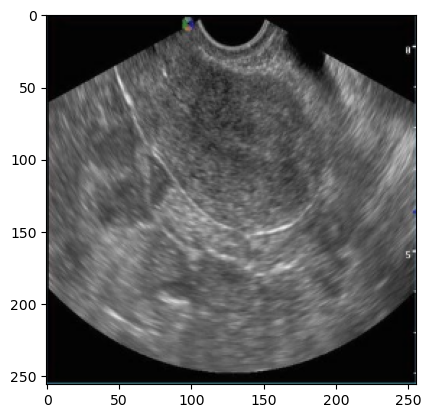

In [60]:
#test the model on real notinfected ultrasound image
test_img = cv2.imread('data/notinfected2.jpg')
resize_notinf_img = tf.image.resize(test_img, (256,256)) #resize the image
plt.imshow(resize_notinf_img.numpy().astype(int))
plt.show()

In [61]:
#make prediction on normalized test image
prd = model.predict(np.expand_dims(resize_notinf_img/255, 0))

1/1 [==============================] - 0s 35ms/step


In [62]:
prd

array([[1.2444354e-10, 1.0000000e+00]], dtype=float32)

In [63]:
if prd[0][1] > 0.5: 
    print(f'Predicted class is Not Infected')
else:
    print(f'Predicted class is Infected')

Predicted class is Not Infected


In [68]:
#save the model
from tensorflow.keras.models import load_model

In [71]:
model.save('PCOSclassifierModel.h5')

In [72]:
new_model = load_model('PCOSclassifierModel.h5')

In [73]:
new_model.predict(np.expand_dims(resize_notinf_img/255, 0))

1/1 [==============================] - 0s 79ms/step


array([[1.2444354e-10, 1.0000000e+00]], dtype=float32)

In [80]:
#Classification using a hybrid CNN-LSTM model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape

input_shape = (256, 256, 3)
model = Sequential()

# CNN Layers for feature extraction
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output of CNN layers
model.add(Flatten())

# Reshape to match the expected input shape of LSTM layer
model.add(Reshape((1, -1)))

# LSTM Layers
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.2))

# Fully connected layers
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

In [81]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#early stopping allows to stop training when valudation loss does not decrease after 15 consequtive epochs.
earlyStopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=15)

In [82]:
history2 = model.fit(
    train_gen,
    validation_data=validation_gen,
    callbacks=[earlyStopping],
    batch_size=batch_size,
    verbose=1,
    epochs=20)

Epoch 1/20
49/49 [==============================] - 92s 2s/step - loss: 0.4889 - accuracy: 0.7747 - val_loss: 0.3021 - val_accuracy: 0.8932
Epoch 2/20
49/49 [==============================] - 87s 2s/step - loss: 0.1739 - accuracy: 0.9500 - val_loss: 0.0767 - val_accuracy: 0.9740
Epoch 3/20
49/49 [==============================] - 87s 2s/step - loss: 0.0437 - accuracy: 0.9883 - val_loss: 0.0122 - val_accuracy: 0.9974
Epoch 4/20
49/49 [==============================] - 88s 2s/step - loss: 0.0531 - accuracy: 0.9890 - val_loss: 0.0106 - val_accuracy: 0.9974
Epoch 5/20
49/49 [==============================] - 87s 2s/step - loss: 0.0474 - accuracy: 0.9864 - val_loss: 0.0080 - val_accuracy: 0.9948
Epoch 6/20
49/49 [==============================] - 87s 2s/step - loss: 0.0191 - accuracy: 0.9942 - val_loss: 0.0178 - val_accuracy: 0.9948
Epoch 7/20
49/49 [==============================] - 89s 2s/step - loss: 0.0230 - accuracy: 0.9922 - val_loss: 0.0086 - val_accuracy: 0.9974
Epoch 8/20
49/49 [==

In [83]:
model.summary() #to view the architecture at every layer

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 30, 30, 128)     

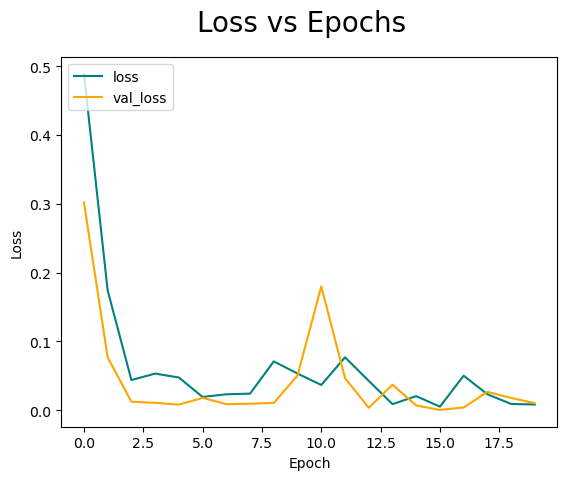

In [84]:
#plot the model training and validation performance loss
fig = plt.figure()
plt.plot(history2.history['loss'], color='teal', label='loss')
plt.plot(history2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss vs Epochs', fontsize=20)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

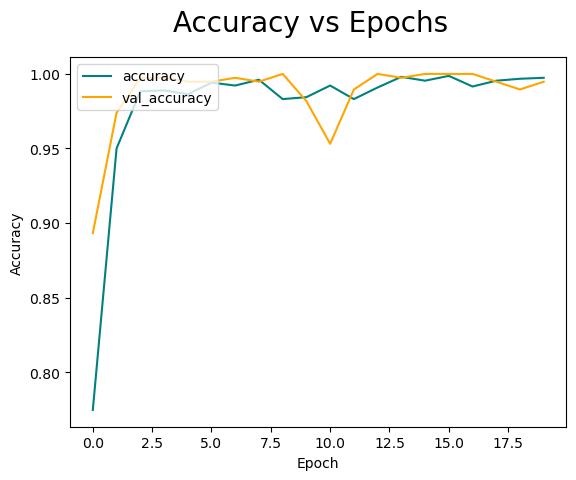

In [85]:
#plot the model training and validation performance accuracy
fig = plt.figure()
plt.plot(history2.history['accuracy'], color='teal', label='accuracy')
plt.plot(history2.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy vs Epochs', fontsize=20)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [86]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
test_data = tf.keras.utils.image_dataset_from_directory('data/test')

Found 1922 files belonging to 2 classes.


In [87]:
#normalize test data
test_data = test_data.map(lambda x,y: (x/255, y))
test_data_iterator = test_data.as_numpy_iterator()
test_data.as_numpy_iterator().next()

(array([[[[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.     

In [88]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [89]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_pred_prob = model.predict(X)
    y_pred_binary = np.argmax(y_pred_prob, axis=1)
    
    pre.update_state(y, y_pred_binary)
    re.update_state(y, y_pred_binary)
    acc.update_state(y, y_pred_binary)

1/1 [==============================] - 0s 269ms/step


In [90]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


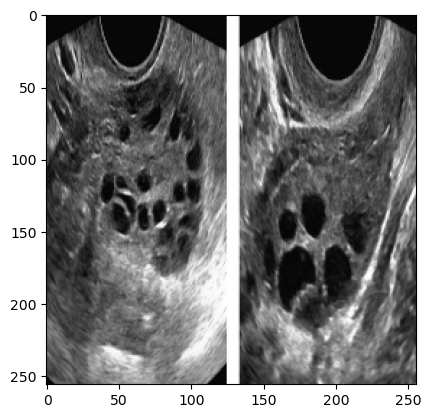

In [91]:
#test the model on real infected ultrasound image
img1 = cv2.imread('data/infected6.png')
resize_inf_img = tf.image.resize(img1, (256,256)) #resize the image
plt.imshow(resize_inf_img.numpy().astype(int))
plt.show()

In [92]:
#make prediction on normalized test image
prd = model.predict(np.expand_dims(resize_inf_img/255, 0))

1/1 [==============================] - 0s 33ms/step


In [93]:
prd

array([[0.74266785, 0.28714728]], dtype=float32)

In [94]:
if prd[0][1] > 0.5: 
    print(f'Predicted class is Not Infected')
else:
    print(f'Predicted class is Infected')

Predicted class is Infected


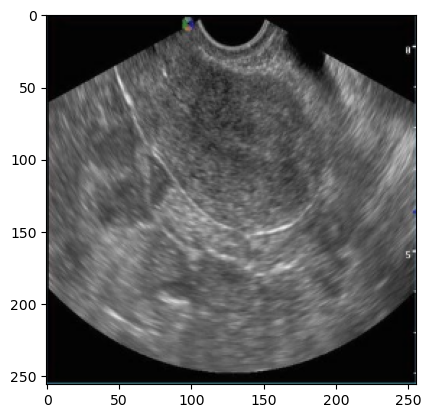

In [95]:
#test the model on real not infected ultrasound image
img = cv2.imread('data/notinfected5.jpg')
resize_ninf_img = tf.image.resize(img, (256,256)) #resize the image
plt.imshow(resize_ninf_img.numpy().astype(int))

In [96]:
#make prediction on normalized test image
prd = model.predict(np.expand_dims(resize_ninf_img/255, 0))

1/1 [==============================] - 0s 34ms/step


In [97]:
prd

array([[2.8808612e-13, 1.0000000e+00]], dtype=float32)

In [98]:
if prd[0][1] > 0.5: 
    print(f'Predicted class is Not Infected')
else:
    print(f'Predicted class is Infected')

Predicted class is Not Infected


In [99]:
#save the model
from tensorflow.keras.models import load_model

In [100]:
model.save('PCOSclassifierModelLSTM.h5')

In [101]:
new_model = load_model('PCOSclassifierModelLSTM.h5')

In [102]:
new_model.predict(np.expand_dims(resize_ninf_img/255, 0))

1/1 [==============================] - 0s 255ms/step


array([[2.8808612e-13, 1.0000000e+00]], dtype=float32)

In [104]:
# Classification with Random Forest Classifier using VGG16 for feature extraction

#install necessary libraries and dependencies
!pip install tensorflow opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [108]:
import tensorflow as tf

In [110]:
#import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16


In [111]:
#define valid image extension for dataset

train_data_dir = 'data/train' #train data directory
test_data_dir = 'data/test' #test data directory

image_exts = ['jpeg','jpg', 'bmp', 'png'] #valid image extensions

In [112]:
#iterate through data and remove dodgy images

def img_ext(data_dir):
    for image_class in os.listdir(data_dir):
        for image in os.listdir(os.path.join(data_dir, image_class)):
            image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            
img_ext(train_data_dir)
img_ext(test_data_dir)

In [113]:
#VGG16 default image size is 224x224, so set desired image

img_size = 256

In [114]:
#Capture training data and labels into respective lists
train_images = []
train_labels = []

In [115]:
for directory_path in os.listdir(train_data_dir):
    label = directory_path.split("\\")[-1]
    print(label)

infected
notinfected


In [125]:
for image_class in os.listdir(train_data_dir):
        for image in os.listdir(os.path.join(train_data_dir, image_class)):
            img_path = os.path.join(train_data_dir, image_class, image)
            print(img_path)

data/train\infected\img1.jpg
data/train\infected\img10.jpg
data/train\infected\img2.jpg
data/train\infected\img3.jpg
data/train\infected\img4.jpg
data/train\infected\img5.jpg
data/train\infected\img6.jpg
data/train\infected\img7.jpg
data/train\infected\img8.jpg
data/train\infected\img_0_1023.jpg
data/train\infected\img_0_1033.jpg
data/train\infected\img_0_1071.jpg
data/train\infected\img_0_1075.jpg
data/train\infected\img_0_1079.jpg
data/train\infected\img_0_1083.jpg
data/train\infected\img_0_1087.jpg
data/train\infected\img_0_1088.jpg
data/train\infected\img_0_1099.jpg
data/train\infected\img_0_113.jpg
data/train\infected\img_0_1130.jpg
data/train\infected\img_0_1141.jpg
data/train\infected\img_0_1142.jpg
data/train\infected\img_0_1182.jpg
data/train\infected\img_0_1195.jpg
data/train\infected\img_0_1223.jpg
data/train\infected\img_0_1226.jpg
data/train\infected\img_0_1234.jpg
data/train\infected\img_0_1257.jpg
data/train\infected\img_0_126.jpg
data/train\infected\img_0_1260.jpg
data/

In [127]:
#append image data and labels to their respective lists

img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
img = cv2.resize(img, (img_size, img_size))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
train_images.append(img)
train_labels.append(label)

In [128]:
#Convert lists to numpy arrays

train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
#repeat process for test/validation data

